**Main imports**

In [18]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
from einops import rearrange
import random

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [19]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


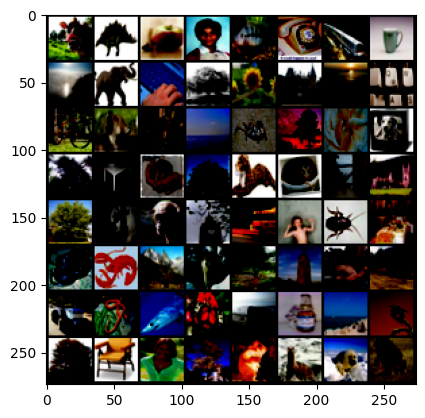

In [20]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

In [21]:
def num_params(model):
    print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(model.parameters()))}')
    if len(torch.nn.utils.parameters_to_vector(model.parameters())) > 1000000:
        print("> Warning: you have gone over your parameter budget and will have a grade penalty!")
    return len(torch.nn.utils.parameters_to_vector(model.parameters()))
    

**This is an autoencoder pretending to be a generative model**

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.ngpu = npgu
        self.main = nn.Sequential(
            # state size 100 x 1 x 1
            nn.ConvTranspose2d(100, 32 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size: (128) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # 128 x 8 x 8
            nn.ConvTranspose2d(32 * 4, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # (64) x 16 x 16
            nn.ConvTranspose2d(32 * 2, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # 64 x 32 x 32
            nn.ConvTranspose2d(32 * 2, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (32) x 32 x 32
            nn.ConvTranspose2d(32, 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size (3) x 32 x 32
        )
        
    def forward(self, x):
        return self.main(x)
    
netG = Generator().to(device)

params_count = num_params(netG)

netG.apply(weights_init)
print(netG)

> Number of model parameters 683680
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. ``(3) x 32 x 32``
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            # state size. ``(32) x 16 x 16``
            nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(64) x 8 x 8``
            nn.Conv2d(32 * 2, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            # 128 x 4 x 4
            nn.Conv2d(32 * 4, 32 * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            # (128) x 4 x 4
            nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)
    
netD = Discriminator().to(device)
print(f"total number of parameters: {num_params(netD) + num_params(netG)}")

> Number of model parameters 315520
> Number of model parameters 683680
total number of parameters: 999200


Model Parameters: 999,200
Generator: 683680
Discriminator: 315520

In [24]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, 100, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
steps = 0
img_list = []
G_losses = np.zeros(0)
D_losses = np.zeros(0)
D_losses_real = np.zeros(0)
D_losses_fake = np.zeros(0)

In [25]:
# def normalise(x):
#     return (x-x.min()) / (x.max()-x.min())

# T = 400
# _ts = torch.randint(1, T+1, (x.shape[0],)).to(device)
# _ts.size()

In [26]:
# eps = torch.randn_like(x)

# beta1 = 1e-4
# beta2 = 0.02
# T = 400

# beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32, device=device) / T + beta1
# alpha_t = 1 - beta_t
# log_alpha_t = torch.log(alpha_t)
# alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

# sqrtab = torch.sqrt(alphabar_t).view(-1,1,1,1)
# sqrtmab = torch.sqrt(1 - alphabar_t).view(-1,1,1,1)

# oneover_sqrta = 1 / torch.sqrt(alpha_t)
# mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab.squeeze()
# sigma_t = torch.sqrt(beta_t)

In [27]:
# x_t = (sqrtab[_ts] * x + sqrtmab[_ts] * eps)

# img_grid = rearrange(torch.cat((x*0.5+0.5, x_t*0.5+0.5, eps), dim=0), '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=3)
# plt.imshow((img_grid.cpu()*255).int().numpy())

In [28]:
# class UNet(nn.Module):
#     def __init__(self, out_class=3):
#         super().__init__()
#         self.dconv_down1 = self.conv_block(32)
#         self.dconv_down2 = self.conv_block(64)
#         #self.dconv_down3 = self.conv_block(64)
#         self.dconv_down4 = self.conv_block(64)
#         self.dconv_down5 = self.conv_block(128)
#         self.bottleneck  = nn.LazyConv2d(128, 3,1,1, bias=False)
#         self.dconv_up4 = self.conv_block(128, up=True)
#         #self.dconv_up3 = self.conv_block(64, up=True)
#         self.dconv_up2 = self.conv_block(64, up=True)
#         self.dconv_up1 = self.conv_block(32, up=True)
#         self.conv_last = nn.LazyConv2d(out_class, 1)
        
#     def conv_block(self, out_channels, up=False):
#         ConvType = nn.LazyConvTranspose2d if up else nn.LazyConv2d
#         return nn.Sequential(
#             ConvType(out_channels, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU())
        
#     def forward(self, x):
#         start = x
#         conv1 = self.dconv_down1(x)     # skip-connection 1
#         conv2 = self.dconv_down2(conv1) # skip-connection 2
#         #conv3 = self.dconv_down3(conv2) # skip-connection 3
#         conv4 = self.dconv_down4(conv2) # skip-connection 4
#         conv5 = self.dconv_down5(conv4)
        
#         x = self.bottleneck(conv4)
#         x = torch.cat([x, conv4], dim=1)
#         x = self.dconv_up4(x)
#         #x = torch.cat([x, conv3], dim=1)
#         #x = self.dconv_up3(x)
#         x = torch.cat([x, conv2], dim=1)
#         x = self.dconv_up2(x)
#         x = torch.cat([x, conv1], dim=1)
#         x = self.dconv_up1(x)
#         x = torch.cat([x, start], dim=1)
#         return self.conv_last(x)

In [29]:
# class DDPM(nn.Module):
#     def __init__(self,):
#         super(DDPM, self).__init__()
#         self.net = UNet()
# #         self.net = nn.Sequential(
# #             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1,padding=1),
# #             nn.ReLU(),
# #             nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3,stride=1,padding=1)
# #         )
        
#     # algorithm 1 in DDPM paper
#     def forward(self, x):
#         _ts = torch.randint(1, T+1, (x.shape[0],)).to(x.device)
#         eps = torch.randn_like(x) 
#         x_t = (sqrtab[_ts] * x + sqrtmab[_ts] * eps)
#         return F.mse_loss(eps, self.net(x_t))
    
#     # algorithm 2 in DDPM paper
#     def sample(self, n_sample, size):
#         x_i = torch.randn(n_sample, *size).to(device)
#         for i in range(T, 0, -1):
#             z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
#             eps = self.net(x_i)
#             x_i = (oneover_sqrta[i] * (x_i - eps * mab_over_sqrtmab_inv[i]) + sigma_t[i] * z )
#         return x_i

In [30]:
# ddpm = DDPM().to(device)
# step = 0
# loss_smooth = 2.00
# optim = torch.optim.Adam(ddpm.parameters(), lr=1e-4)


In [31]:
# ddpm.train()

# while(step < 50000):
#     x,c = next(train_iterator)
#     x,c = x.to(device), c.to(device)

#     loss = ddpm(x)
#     optim.zero_grad()
#     loss.backward()
#     optim.step()

#     loss_smooth = loss_smooth + 0.01 * (loss.item() - loss_smooth)
#     if step % 100 == 0:
#         print('step: {:4d} train loss: {:.3f}'.format(step, loss_smooth), end="\r")

#     step += 1

In [32]:
# x, t = next(train_iterator)
# with torch.no_grad():
#     _ = ddpm(x.to(device))
# #print(ddpm)
# print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(ddpm.parameters()))}')
# #num_params(ddpm)

In [33]:
# # sample the model
# ddpm.eval()
# x,c = next(train_iterator)
# x,c = x.to(device), c.to(device)

# with torch.no_grad():
#     xh = ddpm.sample(10, (3, 32, 32))
    
#     img_grid = rearrange(torch.cat([(xh*0.5+0.5), (x*0.5+0.5)[:10]], dim=0), '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=2)
#     #img_grid = rearrange(torch.cat([(xh), (x)[:10]], dim=0), '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=2)
#     plt.imshow((img_grid.cpu()*255).int().numpy())

**Main training loop**

steps 50000.00, loss: 3.702
discriminator loss: 0.7051725533485412
discriminator loss (real): 0.35324353105161105
discriminator loss (fake): 0.35192902217727157


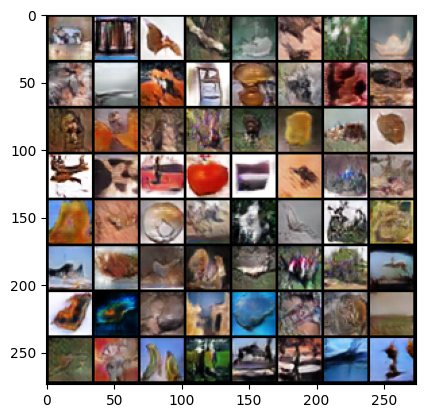

In [34]:
# keep within our optimisation step budget
while (steps < 50000):

    # arrays for metrics
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # train GAN Model
        # UPDATE DISCRIMINATOR
        netD.zero_grad()
        # format batch of real images with labels
        x_size = x.size(0)

        label = torch.full((x_size,), real_label, dtype=torch.float, device=device)
        # forward pass through Discriminator and calculate the loss for back prop.
        output = netD(x).view(-1)

        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train D with all fake image batch
        # generate batch of latent vectors
        noise = torch.randn(x_size, 100, 1, 1, device=device)
        # generate image from noise and assign fake labels
        fake = netG(noise)

        label.fill_(fake_label)
        # classify fake batch and calculate loss on the fake batch
        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)
        # calculate gradients with accumulation from previous gradient calculation
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # compute error over sum of fake and real batches and update with the optimizer
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # UPDATE GENERATOR
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        G_losses = np.append(G_losses, errG.item())
        D_losses = np.append(D_losses, errD.item())
        D_losses_real = np.append(D_losses_real, errD_real.item())
        D_losses_fake = np.append(D_losses_fake, errD_fake.item())
        
        loss_arr = np.append(loss_arr, errG.item())
        
        steps += 1
    print('steps {:.2f}, loss: {:.3f}'.format(steps, loss_arr.mean()))
    print(f"discriminator loss: {D_losses.mean()}")
    print(f"discriminator loss (real): {D_losses_real.mean()}")
    print(f"discriminator loss (fake): {D_losses_fake.mean()}")

    # sample model and visualise results (ensure your sampling code does not use x)
    netG.eval()
    z = torch.randn(64, 100, 1, 1).to(device)
    samples = netG(z).cpu().detach()

    plt.imshow(torchvision.utils.make_grid(samples, normalize=True).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
    plt.show()
    disp.clear_output(wait=True)
    netG.train()

50000


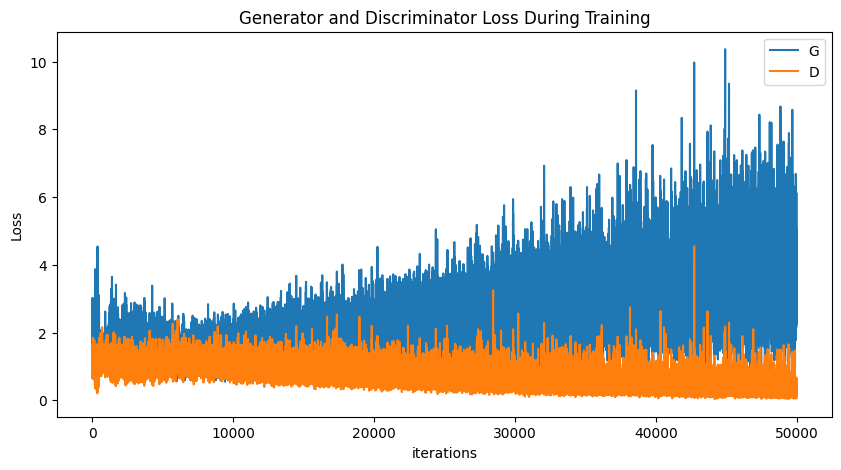

In [35]:
print(len(G_losses))
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
# SAVE THE MODEL
#torch.save(netG.state_dict(), "best-dcgan.pt")

**Latent interpolations**

torch.Size([64, 100])


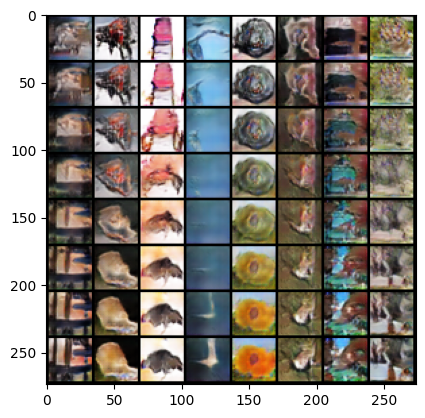

In [37]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(64))
z = torch.randn(64, 100).to(device)
print(z.shape)

z0 = z[0:col_size].repeat(col_size,1) # z for top row
z1 = z[64-col_size:].repeat(col_size,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(64,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = netG(lerp_z.reshape(64, 100, 1, 1)) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g, normalize=True).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [38]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [40]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(64, 100).to(device)
    samples_batch = netG(z.reshape(64, 100, 1, 1)).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [41]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders


/home2/rzgd47/deeplearning/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [01:50<00:00,  2.82it/s]


FID score: 29.579155349566918
